## TODO on Hierarchical Inference

1) Redo the save script to also save the outputs for bnn inference

2) Create function to plot reweighted posterior for lens samples.

3) Track down bug in pdf code.

4) Decide on a specific method for dealing with outlier samples in the interim prior. It's currently hard coded to set them to the boundary, but this will bias inference

In [14]:
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
%matplotlib inline
from ovejero import model_trainer, hierarchical_inference
from multiprocessing import Pool

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## NN1

In [29]:
# First specify the config path
root_path = '/Users/sebwagner/Documents/Grad_School/Rotations/Phil/ovejero/'
config_path = root_path + 'configs/nn1.json'

# We also need the path to the baobab configs for the interim and target omega
interim_baobab_omega_path = root_path + 'configs/baobab_configs/train_diagonal.py'
target_baobab_omega_path = root_path + 'configs/baobab_configs/cent_narrow_shifted_cfg_prior.py'

test_dataset_path = '/Users/sebwagner/Documents/Grad_School/Rotations/Phil/ovejero/datasets/cent_narrow_shifted/'
test_dataset_rf_record_path = test_dataset_path + 'tf_record'

# Check that the config has what you need
cfg = model_trainer.load_config(config_path)

# Correct any path issues.
def recursive_str_checker(cfg_dict):
    for key in cfg_dict:
        if isinstance(cfg_dict[key],str):
            cfg_dict[key] = cfg_dict[key].replace('/home/swagnercarena/ovejero/',root_path)
        if isinstance(cfg_dict[key],dict):
            recursive_str_checker(cfg_dict[key])
recursive_str_checker(cfg)

# The InferenceClass will do all the heavy lifting of preparing the model from the configuration file,
# initializing the validation dataset, and providing outputs correctly marginalized over the BNN uncertainties.
hier_infer = hierarchical_inference.HierarchicalClass(cfg,interim_baobab_omega_path,target_baobab_omega_path,
                                                      test_dataset_path,test_dataset_rf_record_path)

# Now we just have to ask the InferenceClass to spin up some samples from our BNN. The more samples, the more
# accurate our plots and metrics will be. The right value to use unfortunately requires a bit of trial and error.
# 100 is a good starting point though.
num_samples = 10
save_path_samples = '/Users/sebwagner/Documents/Grad_School/Rotations/Phil/ovejero/hierarchical_results/test_samps/'
hier_infer.gen_samples(num_samples,save_path_samples)

Is model built: True
Loaded weights /Users/sebwagner/Documents/Grad_School/Rotations/Phil/ovejero/models/nn1.h5
Generating new TFRecord at /Users/sebwagner/Documents/Grad_School/Rotations/Phil/ovejero/datasets/cent_narrow_shifted/tf_record


100%|██████████| 1028/1028 [00:01<00:00, 833.13it/s]


No samples found. Saving samples to /Users/sebwagner/Documents/Grad_School/Rotations/Phil/ovejero/hierarchical_results/test_samps/
No samples found. Saving samples to /Users/sebwagner/Documents/Grad_School/Rotations/Phil/ovejero/hierarchical_results/test_samps/


100%|██████████| 10/10 [00:54<00:00,  6.06s/it]


In [37]:
n_walkers = 50
save_path_chains = '/Users/sebwagner/Documents/Grad_School/Rotations/Phil/ovejero/hierarchical_results/nn1_chains_test.h5'
pool = Pool()
hier_infer.initialize_sampler(n_walkers,save_path_chains,pool=pool)

No chains found at /Users/sebwagner/Documents/Grad_School/Rotations/Phil/ovejero/hierarchical_results/nn1_chains_test.h5


In [38]:
# %%prun -s cumulative
n_samps = 200
hier_infer.run_sampler(n_samps)

In [39]:
hyperparam_plot_names = [r'$\mu_{\gamma_\mathrm{ext}}$',r'$\sigma_{\gamma_\mathrm{ext}}$',
                         r'$\mu_\psi$',r'$\alpha_\psi$',r'$p_\psi$',
                         r'$\mu_x$',r'$\sigma_x$',r'$\mu_y$',r'$\sigma_y$',
                         r'$\mu_{e1}$',r'$\sigma_{e1}$',
                         r'$\mu_{e2}$',r'$\sigma_{e2}$',
                         r'$\mu_{\gamma_\mathrm{lens}}$',r'$\sigma_{\gamma_\mathrm{lens}}$',
                         r'$\mu_{\theta_E}$',r'$\sigma_{\theta_E}$']

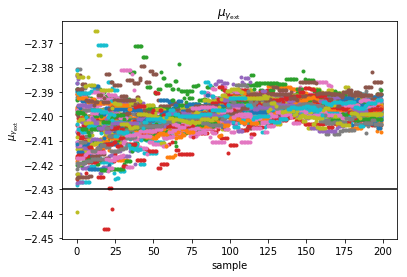

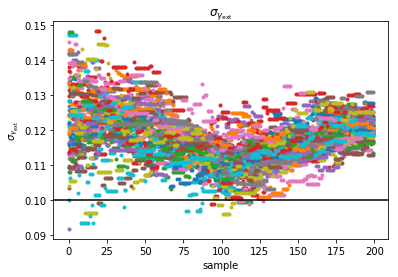

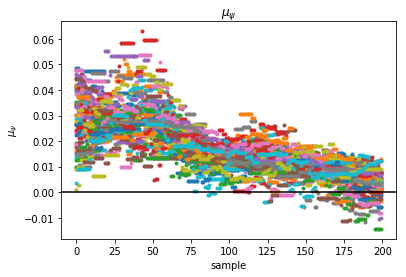

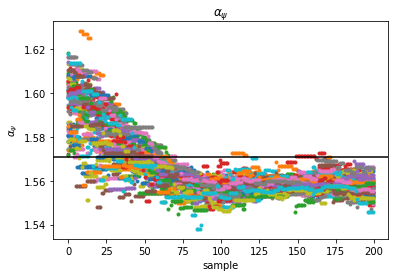

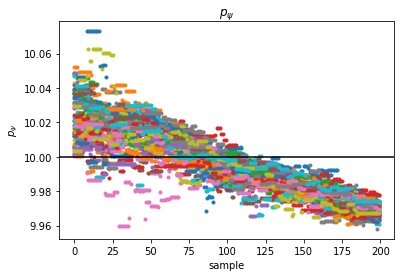

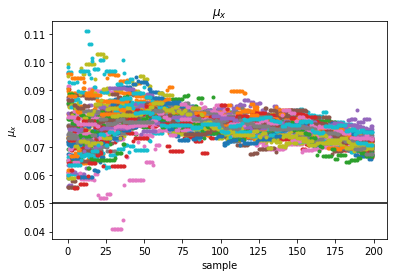

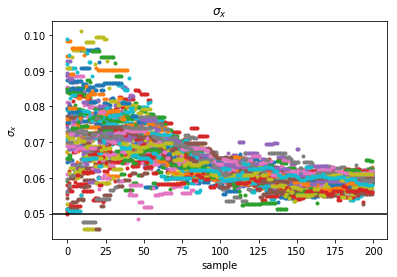

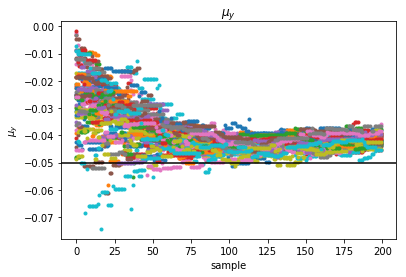

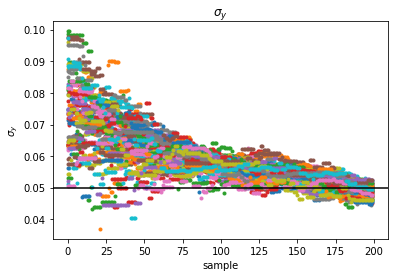

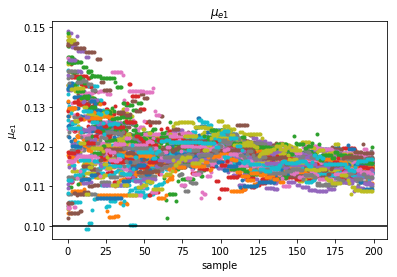

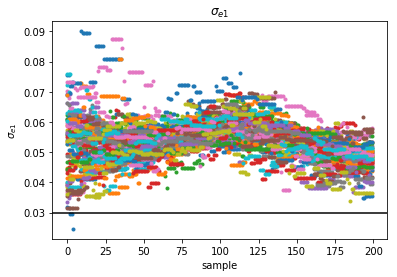

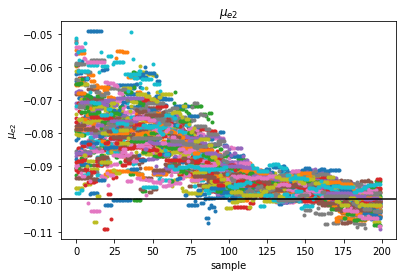

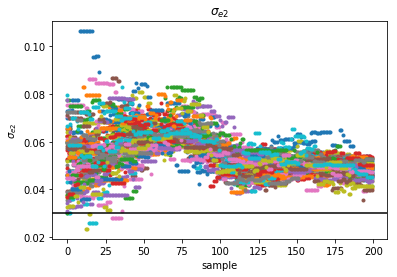

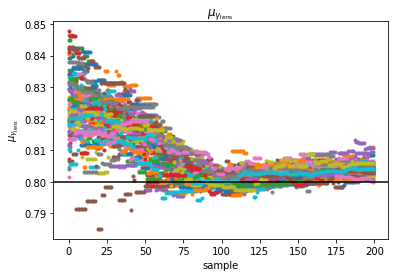

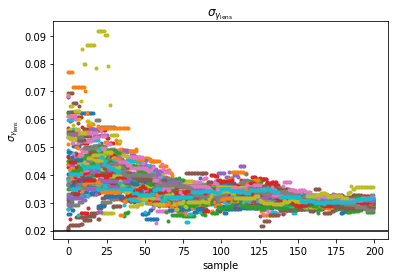

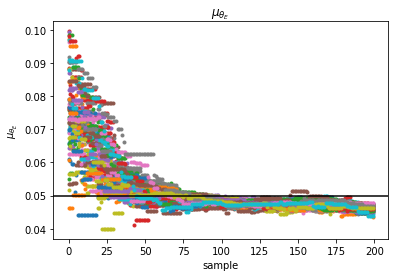

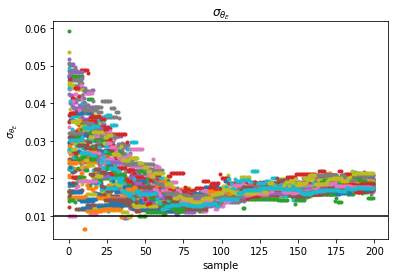

In [40]:
hier_infer.plot_chains(burnin=None,hyperparam_plot_names=hyperparam_plot_names)

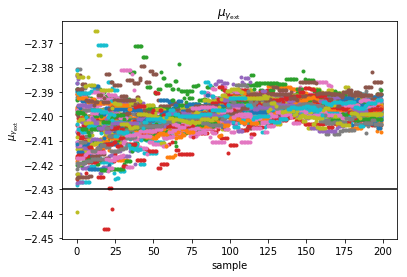

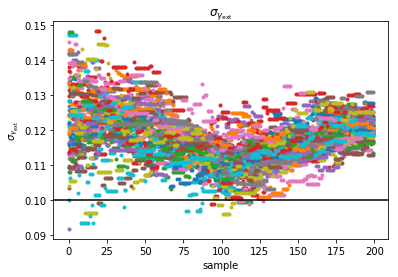

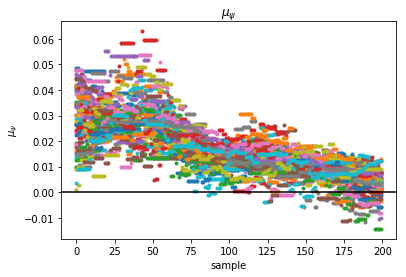

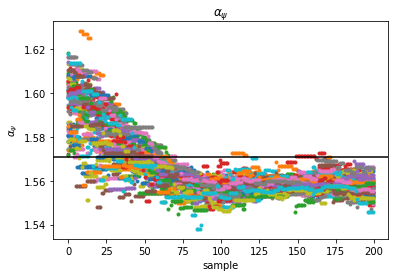

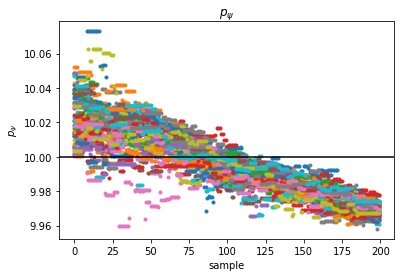

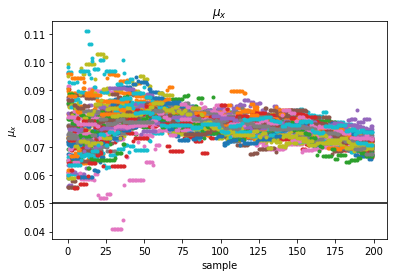

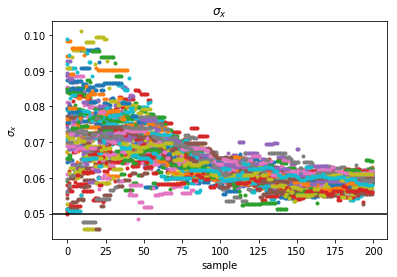

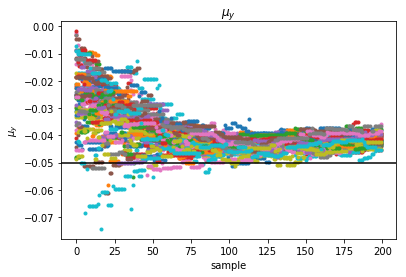

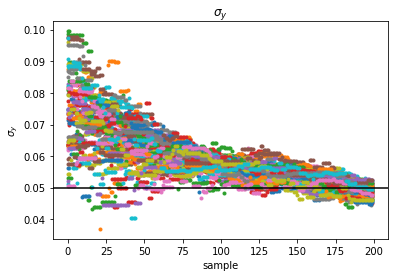

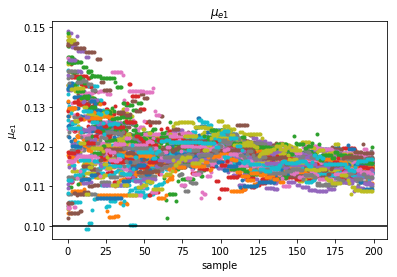

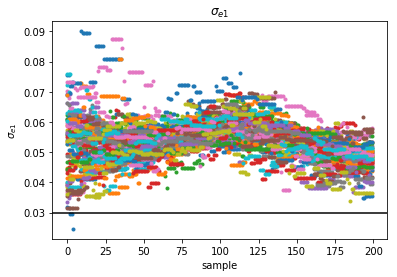

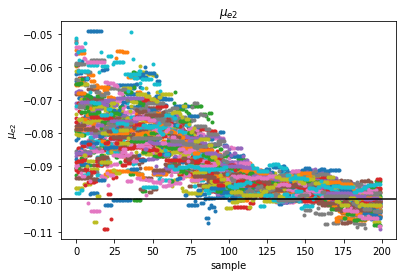

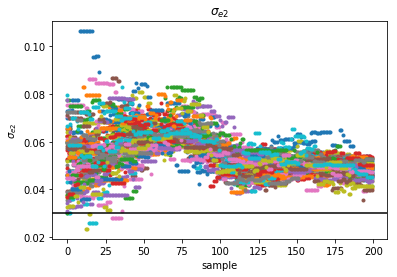

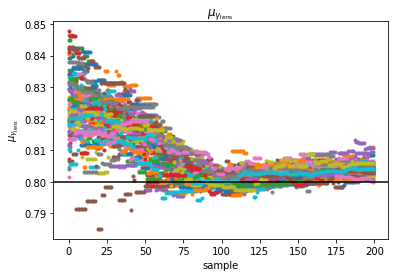

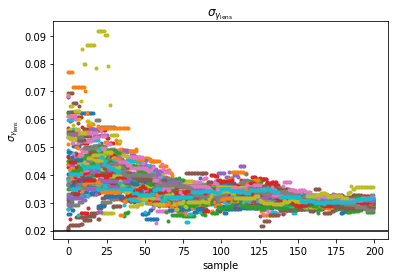

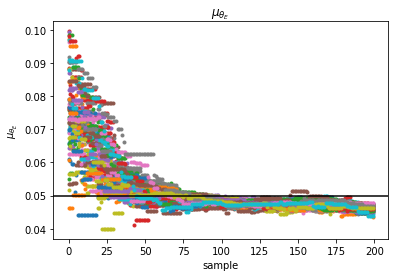

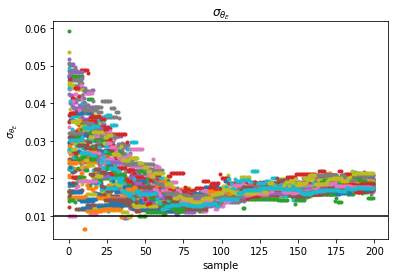

In [41]:
burnin = 0
hier_infer.plot_chains(burnin=burnin,hyperparam_plot_names=hyperparam_plot_names)

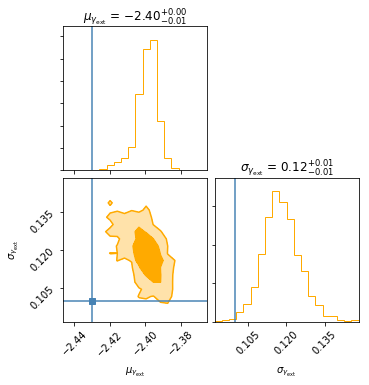

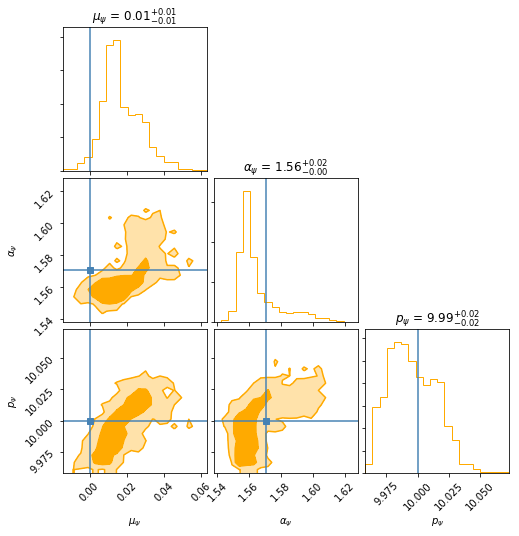

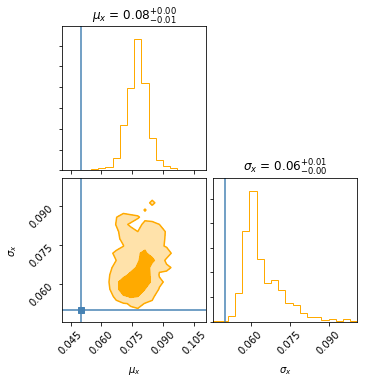

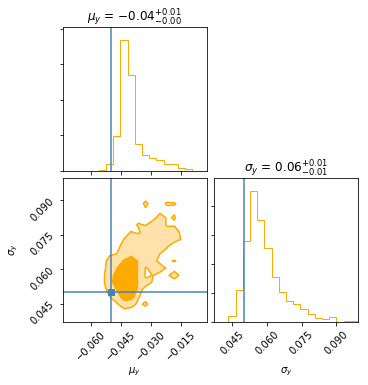

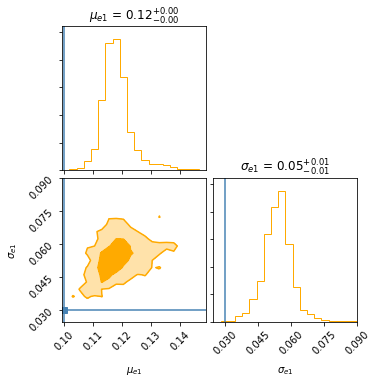

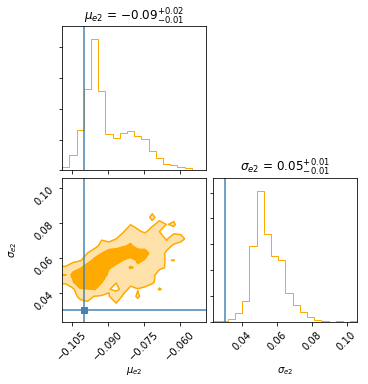

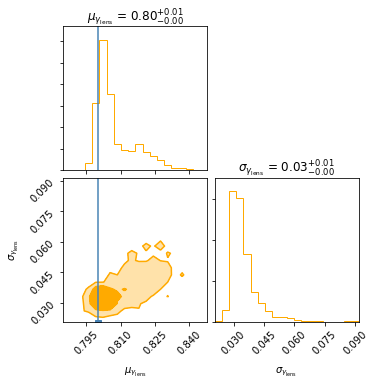

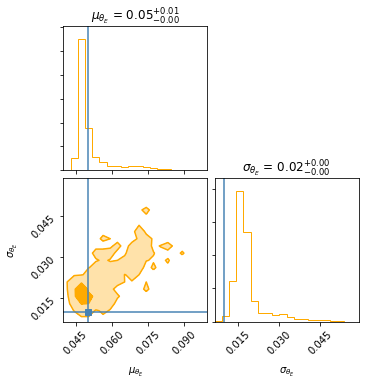

In [42]:
hier_infer.plot_corner(burnin,hyperparam_plot_names)

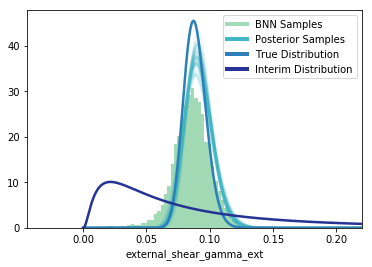

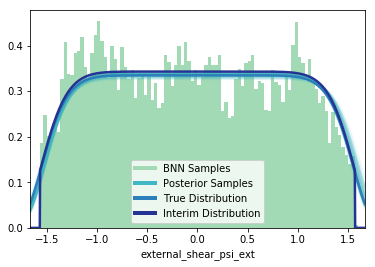

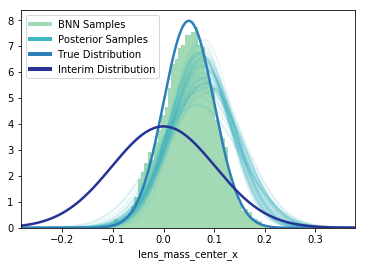

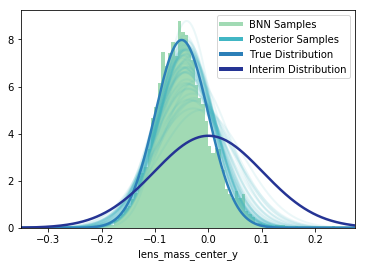

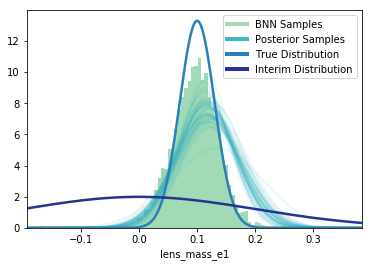

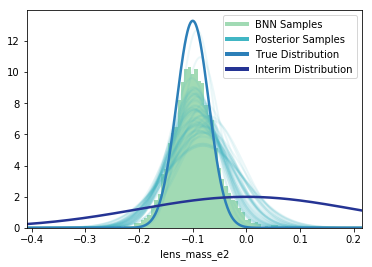

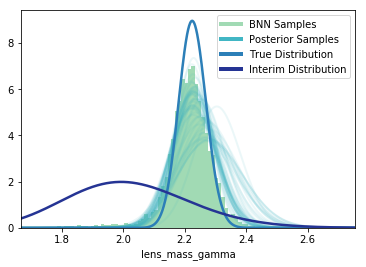

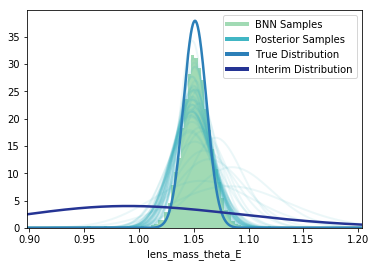

In [43]:
hier_infer.plot_distributions(burnin,hyperparam_plot_names)

In [11]:
image_index = 20
hier_infer.plot_reweighted_lens_posterior(burnin,image_index)

## NN2

In [ ]:
# First specify the config path
config_path = root_path + 'configs/nn2.json'

# Check that the config has what you need
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)

# The InferenceClass will do all the heavy lifting of preparing the model from the configuration file,
# initializing the validation dataset, and providing outputs correctly marginalized over the BNN uncertainties.
hier_infer = hierarchical_inference.HierarchicalClass(cfg,interim_baobab_omega_path,target_baobab_omega_path,
                                                      test_dataset_path,test_dataset_rf_record_path)
num_samples = 1000
save_path_samples = '/Users/sebwagner/Documents/Grad_School/Rotations/Phil/ovejero/hierarchical_results/nn2_samples.npy'
hier_infer.gen_samples(num_samples,save_path_samples)

In [ ]:
n_walkers = 50
save_path_chains = '/Users/sebwagner/Documents/Grad_School/Rotations/Phil/ovejero/hierarchical_results/nn2_chains.h5'
hier_infer.initialize_sampler(n_walkers,save_path_chains)

In [ ]:
hier_infer.plot_chains(burnin=None,hyperparam_plot_names=hyperparam_plot_names)

In [ ]:
burnin = 800
hier_infer.plot_chains(burnin=burnin,hyperparam_plot_names=hyperparam_plot_names)

In [ ]:
hier_infer.plot_corner(burnin,hyperparam_plot_names)

In [ ]:
hier_infer.plot_distributions(burnin,hyperparam_plot_names)

## NN3

In [ ]:
# First specify the config path
config_path = root_path + 'configs/nn3.json'

# Check that the config has what you need
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)

# The InferenceClass will do all the heavy lifting of preparing the model from the configuration file,
# initializing the validation dataset, and providing outputs correctly marginalized over the BNN uncertainties.
hier_infer = hierarchical_inference.HierarchicalClass(cfg,interim_baobab_omega_path,target_baobab_omega_path,
                                                      test_dataset_path,test_dataset_rf_record_path)
num_samples = 1000
save_path_samples = '/Users/sebwagner/Documents/Grad_School/Rotations/Phil/ovejero/hierarchical_results/nn3_samples.npy'
hier_infer.gen_samples(num_samples,save_path_samples)

In [ ]:
n_walkers = 50
save_path_chains = '/Users/sebwagner/Documents/Grad_School/Rotations/Phil/ovejero/hierarchical_results/nn3_chains.h5'
hier_infer.initialize_sampler(n_walkers,save_path_chains)

In [ ]:
hier_infer.plot_chains(burnin=None,hyperparam_plot_names=hyperparam_plot_names)

In [ ]:
burnin = 800
hier_infer.plot_chains(burnin=burnin,hyperparam_plot_names=hyperparam_plot_names)

In [ ]:
hier_infer.plot_corner(burnin,hyperparam_plot_names)

In [ ]:
hier_infer.plot_distributions(burnin,hyperparam_plot_names)

In [ ]:
import numba
import numpy as np
from math import gamma
@numba.njit
def _beta_log_pdf_numba(eval_at,a,b):
    return np.log(eval_at)*(a-1)+np.log(1-eval_at)*(b-1)

@numba.njit
def eval_beta_logpdf_approx(eval_at,a,b,lower,upper):
    """Evaluate the beta pdf, scaled/shifted without -np.inf

    See `sample_beta` for parameter definitions.

    """

    # Terms we only want to calculate once
    norm = np.log(gamma(a+b)/(gamma(a)*gamma(b)))
    scale = upper - lower
    lscale = np.log(scale)

    # Epsilon parameter for approximation
    epsilon = 1e-9/scale

    # The evaluations
    eval_logpdf = _beta_log_pdf_numba((eval_at-lower)/scale,a,b)-lscale+norm
    stitch_upper = _beta_log_pdf_numba(1-epsilon,a,b)-lscale+norm
    stitch_lower = _beta_log_pdf_numba(epsilon,a,b)-lscale+norm

    # For loops are not a problem with numba
    for e_i in range(eval_at.shape[0]):
        for e_j in range(eval_at.shape[1]):
            if eval_at[e_i,e_j] < lower+epsilon:
                eval_logpdf[e_i,e_j] = stitch_lower - np.abs(eval_at[e_i,e_j] 
                    - lower -  epsilon)
            if eval_at[e_i,e_j] > upper-epsilon:
                eval_logpdf[e_i,e_j] = stitch_upper - np.abs(eval_at[e_i,e_j] 
                    - upper + epsilon)
    return eval_logpdf

In [ ]:
eval_beta_logpdf_approx(hier_infer.lens_samps[5],*[4,4,-1.5,1.5])